<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s6/EVA4_Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import numpy as np

In [2]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Cuda available?', use_cuda)

Cuda available? True


In [3]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4')
except:
  print('May be not using Google Colab')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from utils.model_helper import train_model, test_model, train_n_test
from utils.plot_helper import plot_acc_loss

In [0]:
class_names  = [ "zero",  # index 0
                 "one",   # index 1
                 "two",   # index 2 
                 "three", # index 3 
                 "four",  # index 4
                 "five",  # index 5
                 "six",   # index 6 
                 "seven", # index 7 
                 "eight", # index 8 
                 "nine"]  # index 9

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [7]:
# Prepare Train and Test Dataset

train_dataset = datasets.MNIST('../data', train=True, download=True, transform= train_transforms)
test_dataset = datasets.MNIST('../data', train=False, transform=test_transforms)

x_test = test_dataset.test_data.cpu().numpy()
y_test = test_dataset.test_labels.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
SEED = 1

torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True, 'batch_size': batch_size} if use_cuda else {'batch_size': 64}
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader( test_dataset , shuffle=True, **kwargs)


In [0]:
def model_pred(model, device, test_data_set):
    model.eval()
    data_loader_args = dict(shuffle=False, batch_size=test_data_set.test_data.cpu().numpy().shape[0], num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=10000)
    test_loader = torch.utils.data.DataLoader(test_data_set, **data_loader_args)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        pred = pred.cpu().numpy()
    print(confusion_matrix(test_data_set.test_labels.cpu().numpy(), pred.reshape(-1)))
    print('\n')
    print(classification_report(test_data_set.test_labels.cpu().numpy(), pred.reshape(-1), target_names=class_names))
    return pred



def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(30,9))
    fig.suptitle(title_str, fontsize=18)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            try:
              img_num = np.random.randint(features_idx.shape[0])
            except:
              continue
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(i) + ' Pred:{} '.format(y_pred[intsct[img_num]][0]), fontsize=20)
            plt.imshow(im)
    plt.show()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


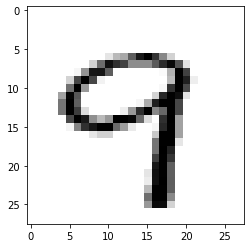

In [10]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_dataset.train_data
train_data = train_dataset.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


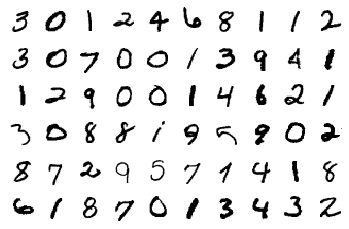

In [11]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:26x26x8, output:24x24x8, RF:5x5
        
        self.pool1 = nn.MaxPool2d(2, 2) #input - 24*24*8 output: 12*12*8 RF: 6*6
        self.conv_one_one_1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:12x12x8, output:12x12x8, RF:6x6

        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:12x12x8, output:10x10x16, RF:10x10
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x20, RF:22x22

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )  #input -6*6*20 output: 1*1*20 RF:32x32

        self.conv_one_one_2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x20, output:1x1x10,


    def forward(self, x):
        x = self.conv_block2(self.conv_block1(x))

        x = self.conv_one_one_1(self.pool1(x))

        x = self.conv_block4(self.conv_block3(x))
        x = self.conv_block6(self.conv_block5(x))

        x = self.gap(x)
        x = self.conv_one_one_2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
from torch.optim.lr_scheduler import StepLR
EPOCHS = 40
init_learning_rate = 0.199
gamma= (init_learning_rate - (0.0001/EPOCHS))/init_learning_rate

# No L1 / L2

In [14]:
model1 = Net().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

Epoch: 1, Batch 937,  Training Loss: 0.01789793 Training Accuracy: 93.0667%: 100%|██████████| 938/938 [00:17<00:00, 52.45it/s]

LR: [0.199]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 -- Test Set, Validation Loss: 0.06569162 Validation Accuracy: 97.8900%



Epoch: 2, Batch 937,  Training Loss: 0.22941594 Training Accuracy: 97.4233%: 100%|██████████| 938/938 [00:17<00:00, 53.37it/s]


LR: [0.19899500003140708]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 -- Test Set, Validation Loss: 0.03946629 Validation Accuracy: 98.8900%



Epoch: 3, Batch 937,  Training Loss: 0.03566696 Training Accuracy: 97.8083%: 100%|██████████| 938/938 [00:17<00:00, 54.93it/s]


LR: [0.19899250009422076]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 -- Test Set, Validation Loss: 0.02996082 Validation Accuracy: 99.0600%



Epoch: 4, Batch 937,  Training Loss: 0.04987758 Training Accuracy: 98.2100%: 100%|██████████| 938/938 [00:16<00:00, 56.16it/s]

LR: [0.1989900001884407]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 -- Test Set, Validation Loss: 0.02638347 Validation Accuracy: 99.0600%



Epoch: 5, Batch 937,  Training Loss: 0.31498545 Training Accuracy: 98.3883%: 100%|██████████| 938/938 [00:17<00:00, 54.07it/s]


LR: [0.1989875003140665]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 -- Test Set, Validation Loss: 0.03159244 Validation Accuracy: 99.0400%



Epoch: 6, Batch 937,  Training Loss: 0.00160167 Training Accuracy: 98.4967%: 100%|██████████| 938/938 [00:17<00:00, 54.58it/s]

LR: [0.19898500047109777]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 -- Test Set, Validation Loss: 0.02700956 Validation Accuracy: 99.1000%



Epoch: 7, Batch 937,  Training Loss: 0.05671726 Training Accuracy: 98.5000%: 100%|██████████| 938/938 [00:16<00:00, 56.95it/s]


LR: [0.19898250065953407]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 -- Test Set, Validation Loss: 0.02407911 Validation Accuracy: 99.1000%



Epoch: 8, Batch 937,  Training Loss: 0.14084384 Training Accuracy: 98.6133%: 100%|██████████| 938/938 [00:16<00:00, 57.55it/s]

LR: [0.19898000087937506]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 -- Test Set, Validation Loss: 0.02918778 Validation Accuracy: 99.1300%



Epoch: 9, Batch 937,  Training Loss: 0.19917974 Training Accuracy: 98.6600%: 100%|██████████| 938/938 [00:16<00:00, 56.41it/s]

LR: [0.19897750113062032]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 -- Test Set, Validation Loss: 0.02552752 Validation Accuracy: 99.2300%



Epoch: 10, Batch 937,  Training Loss: 0.03003646 Training Accuracy: 98.7533%: 100%|██████████| 938/938 [00:16<00:00, 57.65it/s]

LR: [0.19897500141326946]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 -- Test Set, Validation Loss: 0.02191814 Validation Accuracy: 99.3100%



Epoch: 11, Batch 937,  Training Loss: 0.01584478 Training Accuracy: 98.6650%: 100%|██████████| 938/938 [00:16<00:00, 58.04it/s]

LR: [0.1989725017273221]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 -- Test Set, Validation Loss: 0.02591518 Validation Accuracy: 99.2800%



Epoch: 12, Batch 937,  Training Loss: 0.00422476 Training Accuracy: 98.7550%: 100%|██████████| 938/938 [00:16<00:00, 58.58it/s]

LR: [0.1989700020727778]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 -- Test Set, Validation Loss: 0.02179348 Validation Accuracy: 99.2500%



Epoch: 13, Batch 937,  Training Loss: 0.00076362 Training Accuracy: 98.8300%: 100%|██████████| 938/938 [00:16<00:00, 57.15it/s]

LR: [0.19896750244963618]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 -- Test Set, Validation Loss: 0.02140731 Validation Accuracy: 99.2900%



Epoch: 14, Batch 937,  Training Loss: 0.02375561 Training Accuracy: 98.7867%: 100%|██████████| 938/938 [00:15<00:00, 58.98it/s]

LR: [0.1989650028578969]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 -- Test Set, Validation Loss: 0.01961993 Validation Accuracy: 99.4000%



Epoch: 15, Batch 937,  Training Loss: 0.02704003 Training Accuracy: 98.8000%: 100%|██████████| 938/938 [00:17<00:00, 55.17it/s]


LR: [0.19896250329755952]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 -- Test Set, Validation Loss: 0.02709991 Validation Accuracy: 99.2600%



Epoch: 16, Batch 937,  Training Loss: 0.01461859 Training Accuracy: 98.9283%: 100%|██████████| 938/938 [00:16<00:00, 57.09it/s]

LR: [0.19896000376862363]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 -- Test Set, Validation Loss: 0.01899938 Validation Accuracy: 99.3800%



Epoch: 17, Batch 937,  Training Loss: 0.00395206 Training Accuracy: 98.9233%: 100%|██████████| 938/938 [00:16<00:00, 55.78it/s]

LR: [0.19895750427108888]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 -- Test Set, Validation Loss: 0.02342539 Validation Accuracy: 99.2200%



Epoch: 18, Batch 937,  Training Loss: 0.05163634 Training Accuracy: 99.0000%: 100%|██████████| 938/938 [00:16<00:00, 58.06it/s]

LR: [0.19895500480495484]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 -- Test Set, Validation Loss: 0.02168279 Validation Accuracy: 99.2800%



Epoch: 19, Batch 937,  Training Loss: 0.14733261 Training Accuracy: 98.9300%: 100%|██████████| 938/938 [00:16<00:00, 57.06it/s]

LR: [0.19895250537022113]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 -- Test Set, Validation Loss: 0.02012989 Validation Accuracy: 99.2900%



Epoch: 20, Batch 937,  Training Loss: 0.01222798 Training Accuracy: 98.9650%: 100%|██████████| 938/938 [00:16<00:00, 57.48it/s]

LR: [0.19895000596688736]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 20 -- Test Set, Validation Loss: 0.02119977 Validation Accuracy: 99.3600%



Epoch: 21, Batch 937,  Training Loss: 0.00130570 Training Accuracy: 98.9533%: 100%|██████████| 938/938 [00:16<00:00, 56.38it/s]

LR: [0.1989475065949531]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 21 -- Test Set, Validation Loss: 0.02092518 Validation Accuracy: 99.3900%



Epoch: 22, Batch 937,  Training Loss: 0.00476980 Training Accuracy: 98.9867%: 100%|██████████| 938/938 [00:16<00:00, 57.18it/s]

LR: [0.19894500725441802]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 22 -- Test Set, Validation Loss: 0.02623470 Validation Accuracy: 99.2200%



Epoch: 23, Batch 937,  Training Loss: 0.00376648 Training Accuracy: 99.0767%: 100%|██████████| 938/938 [00:16<00:00, 56.85it/s]

LR: [0.19894250794528168]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 23 -- Test Set, Validation Loss: 0.02207042 Validation Accuracy: 99.2400%



Epoch: 24, Batch 937,  Training Loss: 0.00155029 Training Accuracy: 98.9667%: 100%|██████████| 938/938 [00:16<00:00, 56.03it/s]

LR: [0.1989400086675437]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 24 -- Test Set, Validation Loss: 0.01929039 Validation Accuracy: 99.3600%



Epoch: 25, Batch 937,  Training Loss: 0.02148262 Training Accuracy: 99.0300%: 100%|██████████| 938/938 [00:16<00:00, 56.02it/s]

LR: [0.19893750942120367]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 25 -- Test Set, Validation Loss: 0.02174526 Validation Accuracy: 99.3400%



Epoch: 26, Batch 937,  Training Loss: 0.02502120 Training Accuracy: 99.0117%: 100%|██████████| 938/938 [00:16<00:00, 57.19it/s]

LR: [0.1989350102062612]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 26 -- Test Set, Validation Loss: 0.02053582 Validation Accuracy: 99.3900%



Epoch: 27, Batch 937,  Training Loss: 0.12002537 Training Accuracy: 99.0533%: 100%|██████████| 938/938 [00:16<00:00, 57.10it/s]


LR: [0.19893251102271592]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 27 -- Test Set, Validation Loss: 0.01920761 Validation Accuracy: 99.3800%



Epoch: 28, Batch 937,  Training Loss: 0.00758091 Training Accuracy: 99.0817%: 100%|██████████| 938/938 [00:17<00:00, 54.93it/s]

LR: [0.1989300118705674]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 28 -- Test Set, Validation Loss: 0.02277868 Validation Accuracy: 99.2800%



Epoch: 29, Batch 937,  Training Loss: 0.03159395 Training Accuracy: 99.0300%: 100%|██████████| 938/938 [00:16<00:00, 57.22it/s]


LR: [0.1989275127498153]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 29 -- Test Set, Validation Loss: 0.01762929 Validation Accuracy: 99.4200%



Epoch: 30, Batch 937,  Training Loss: 0.07017556 Training Accuracy: 99.1067%: 100%|██████████| 938/938 [00:16<00:00, 55.94it/s]

LR: [0.19892501366045917]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 30 -- Test Set, Validation Loss: 0.01810821 Validation Accuracy: 99.4300%



Epoch: 31, Batch 937,  Training Loss: 0.00866862 Training Accuracy: 99.1350%: 100%|██████████| 938/938 [00:16<00:00, 56.30it/s]

LR: [0.19892251460249863]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 31 -- Test Set, Validation Loss: 0.02179250 Validation Accuracy: 99.2700%



Epoch: 32, Batch 937,  Training Loss: 0.00586233 Training Accuracy: 99.0717%: 100%|██████████| 938/938 [00:17<00:00, 54.76it/s]

LR: [0.19892001557593328]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 32 -- Test Set, Validation Loss: 0.01703117 Validation Accuracy: 99.4400%



Epoch: 33, Batch 937,  Training Loss: 0.01803264 Training Accuracy: 99.1683%: 100%|██████████| 938/938 [00:16<00:00, 56.97it/s]

LR: [0.19891751658076276]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 33 -- Test Set, Validation Loss: 0.02105941 Validation Accuracy: 99.2900%



Epoch: 34, Batch 937,  Training Loss: 0.00006944 Training Accuracy: 99.0883%: 100%|██████████| 938/938 [00:17<00:00, 54.79it/s]

LR: [0.19891501761698663]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 34 -- Test Set, Validation Loss: 0.02286578 Validation Accuracy: 99.2900%



Epoch: 35, Batch 937,  Training Loss: 0.00324471 Training Accuracy: 99.1700%: 100%|██████████| 938/938 [00:16<00:00, 56.55it/s]


LR: [0.19891251868460452]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 35 -- Test Set, Validation Loss: 0.02213736 Validation Accuracy: 99.2500%



Epoch: 36, Batch 937,  Training Loss: 0.00136951 Training Accuracy: 99.1300%: 100%|██████████| 938/938 [00:16<00:00, 56.65it/s]

LR: [0.19891001978361605]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 36 -- Test Set, Validation Loss: 0.01995244 Validation Accuracy: 99.3600%



Epoch: 37, Batch 937,  Training Loss: 0.03271393 Training Accuracy: 99.1200%: 100%|██████████| 938/938 [00:16<00:00, 55.12it/s]

LR: [0.1989075209140208]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 37 -- Test Set, Validation Loss: 0.02427096 Validation Accuracy: 99.2700%



Epoch: 38, Batch 937,  Training Loss: 0.00281768 Training Accuracy: 99.1150%: 100%|██████████| 938/938 [00:16<00:00, 57.64it/s]

LR: [0.1989050220758184]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 38 -- Test Set, Validation Loss: 0.01941798 Validation Accuracy: 99.3400%



Epoch: 39, Batch 937,  Training Loss: 0.03005108 Training Accuracy: 99.1350%: 100%|██████████| 938/938 [00:16<00:00, 57.16it/s]


LR: [0.19890252326900842]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 39 -- Test Set, Validation Loss: 0.01869199 Validation Accuracy: 99.3800%



Epoch: 40, Batch 937,  Training Loss: 0.00165468 Training Accuracy: 99.1517%: 100%|██████████| 938/938 [00:16<00:00, 57.76it/s]

LR: [0.19890002449359048]



Epoch: 40 -- Test Set, Validation Loss: 0.02249942 Validation Accuracy: 99.2800%



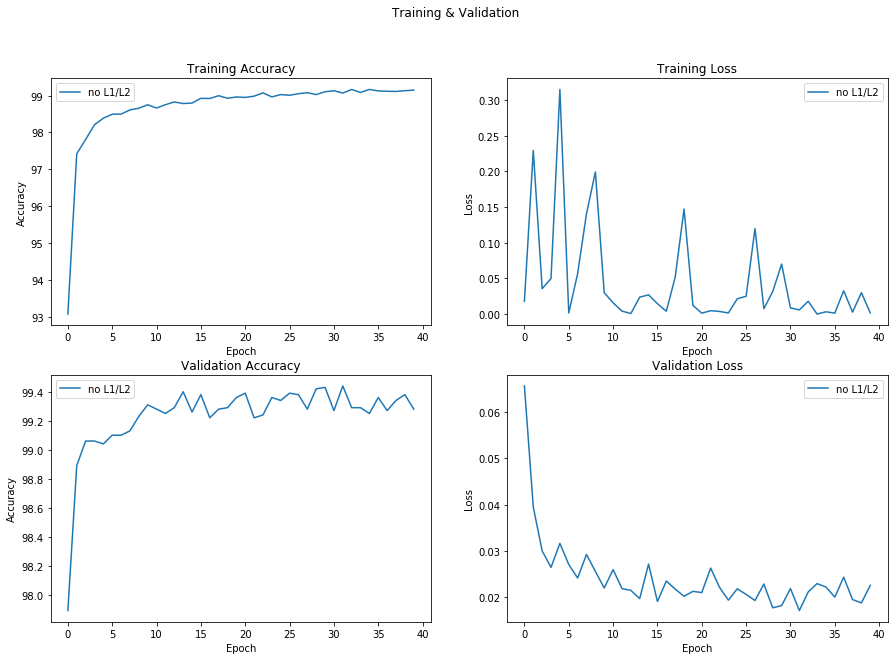

In [15]:
optimizer1 = optim.SGD(model1.parameters(), lr=init_learning_rate, momentum=0.9)
scheduler1 = StepLR(optimizer1, step_size=1, gamma=gamma)

[(train_acc_1, train_loss_1), (val_acc_1, val_loss_1)] = train_n_test(model1, optimizer1, scheduler1, device, train_loader, test_loader, EPOCHS)

plot_acc_loss({'no L1/L2': train_acc_1}, 
              {'no L1/L2': val_acc_1},
              {'no L1/L2': train_loss_1},
              {'no L1/L2': val_loss_1}
              )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1132    1    1    0    0    1    0    0    0]
 [   1    1 1027    0    0    0    1    2    0    0]
 [   0    1    2  999    0    6    0    1    1    0]
 [   0    0    0    0  979    0    1    0    1    1]
 [   0    0    0    3    0  888    1    0    0    0]
 [   7    3    0    0    0    1  946    0    1    0]
 [   0    9    5    0    0    0    0 1013    0    1]
 [   3    0    1    1    0    1    1    0  966    1]
 [   0    1    0    0    4    0    0    3    3  998]]


              precision    recall  f1-score   support

        zero       0.99      1.00      0.99       980
         one       0.99      1.00      0.99      1135
         two       0.99      1.00      0.99      1032
       three       1.00      0.99      0.99      1010
        four       1.00      1.00      1.00       982
        five       0.99      1.00      0.99       892
         six       0.99      0.99      0.99       958
       seven       0.99      0.99 

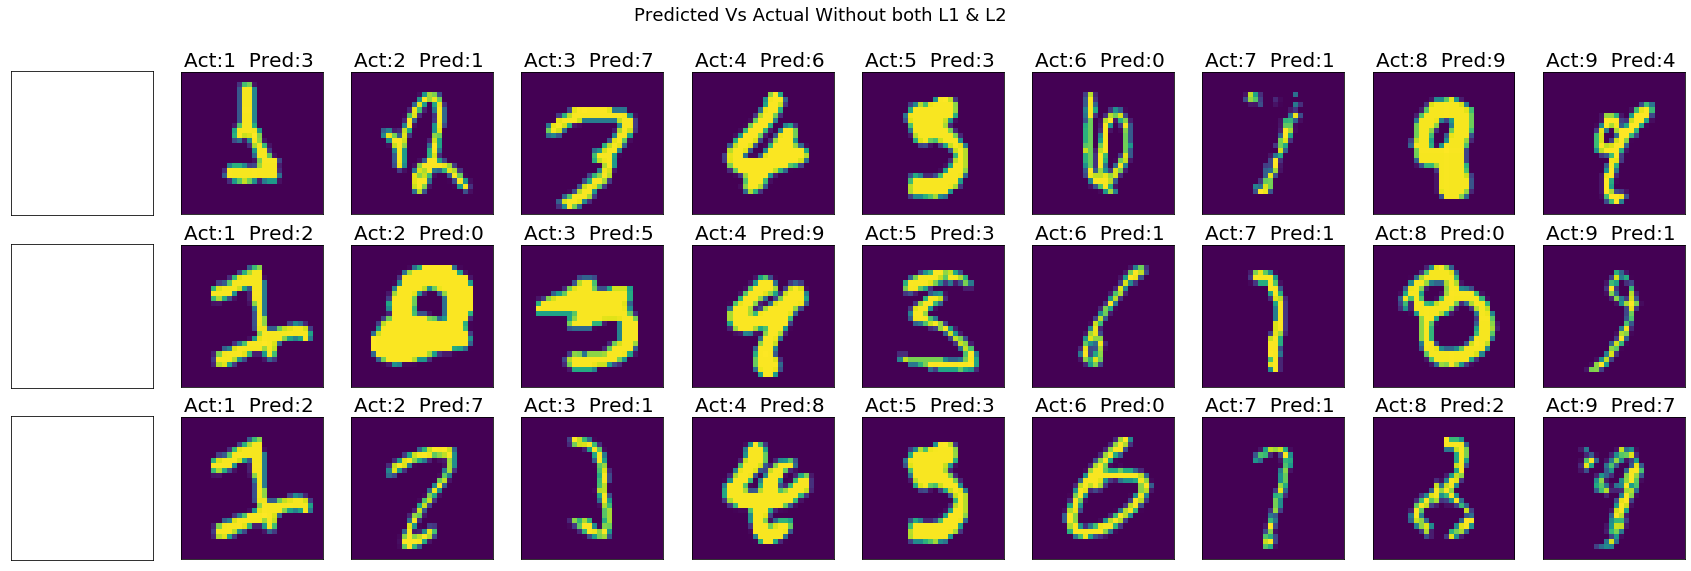

In [16]:
y_pred_1 = model_pred(model1, device, test_dataset)
display_mislabelled(model1, device, x_test, y_test.reshape(-1,1), y_pred_1, 'Predicted Vs Actual Without both L1 & L2')

# Only L1

Epoch: 1, Batch 937,  Training Loss: 0.26545599 Training Accuracy: 93.3150%: 100%|██████████| 938/938 [00:17<00:00, 54.80it/s]


LR: [0.199]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 -- Test Set, Validation Loss: 0.07597717 Validation Accuracy: 97.6000%



Epoch: 2, Batch 937,  Training Loss: 0.27035040 Training Accuracy: 97.1317%: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]

LR: [0.19899500003140708]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 -- Test Set, Validation Loss: 0.06354331 Validation Accuracy: 97.9100%



Epoch: 3, Batch 937,  Training Loss: 0.20998777 Training Accuracy: 97.3183%: 100%|██████████| 938/938 [00:16<00:00, 56.12it/s]

LR: [0.19899250009422076]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 -- Test Set, Validation Loss: 0.05517377 Validation Accuracy: 98.3000%



Epoch: 4, Batch 937,  Training Loss: 0.42259327 Training Accuracy: 97.3167%: 100%|██████████| 938/938 [00:17<00:00, 54.88it/s]


LR: [0.1989900001884407]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 -- Test Set, Validation Loss: 0.06787826 Validation Accuracy: 97.8000%



Epoch: 5, Batch 937,  Training Loss: 0.21270771 Training Accuracy: 97.4917%: 100%|██████████| 938/938 [00:16<00:00, 55.45it/s]

LR: [0.1989875003140665]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 -- Test Set, Validation Loss: 0.04290506 Validation Accuracy: 98.5600%



Epoch: 6, Batch 937,  Training Loss: 0.15368755 Training Accuracy: 97.4817%: 100%|██████████| 938/938 [00:16<00:00, 55.66it/s]


LR: [0.19898500047109777]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 -- Test Set, Validation Loss: 0.05083424 Validation Accuracy: 98.4400%



Epoch: 7, Batch 937,  Training Loss: 0.24905933 Training Accuracy: 97.6467%: 100%|██████████| 938/938 [00:17<00:00, 54.77it/s]

LR: [0.19898250065953407]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 -- Test Set, Validation Loss: 0.04608583 Validation Accuracy: 98.5500%



Epoch: 8, Batch 937,  Training Loss: 0.15841207 Training Accuracy: 97.4783%: 100%|██████████| 938/938 [00:17<00:00, 54.28it/s]

LR: [0.19898000087937506]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 -- Test Set, Validation Loss: 0.05332901 Validation Accuracy: 98.3400%



Epoch: 9, Batch 937,  Training Loss: 0.16553588 Training Accuracy: 97.6083%: 100%|██████████| 938/938 [00:16<00:00, 56.18it/s]


LR: [0.19897750113062032]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 -- Test Set, Validation Loss: 0.05560687 Validation Accuracy: 98.2800%



Epoch: 10, Batch 937,  Training Loss: 0.19098319 Training Accuracy: 97.6233%: 100%|██████████| 938/938 [00:16<00:00, 55.82it/s]

LR: [0.19897500141326946]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 -- Test Set, Validation Loss: 0.05388437 Validation Accuracy: 98.3200%



Epoch: 11, Batch 937,  Training Loss: 0.20367344 Training Accuracy: 97.5900%: 100%|██████████| 938/938 [00:17<00:00, 54.28it/s]

LR: [0.1989725017273221]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 -- Test Set, Validation Loss: 0.06368432 Validation Accuracy: 98.0400%



Epoch: 12, Batch 937,  Training Loss: 0.15232503 Training Accuracy: 97.6150%: 100%|██████████| 938/938 [00:17<00:00, 53.75it/s]

LR: [0.1989700020727778]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 -- Test Set, Validation Loss: 0.03911019 Validation Accuracy: 98.7300%



Epoch: 13, Batch 937,  Training Loss: 0.15019435 Training Accuracy: 97.7983%: 100%|██████████| 938/938 [00:16<00:00, 56.03it/s]

LR: [0.19896750244963618]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 -- Test Set, Validation Loss: 0.03899967 Validation Accuracy: 98.7300%



Epoch: 14, Batch 937,  Training Loss: 0.25742954 Training Accuracy: 97.5883%: 100%|██████████| 938/938 [00:16<00:00, 55.71it/s]

LR: [0.1989650028578969]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 -- Test Set, Validation Loss: 0.03723128 Validation Accuracy: 98.7600%



Epoch: 15, Batch 937,  Training Loss: 0.19699809 Training Accuracy: 97.7350%: 100%|██████████| 938/938 [00:16<00:00, 55.93it/s]

LR: [0.19896250329755952]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 -- Test Set, Validation Loss: 0.04333438 Validation Accuracy: 98.6500%



Epoch: 16, Batch 937,  Training Loss: 0.31089246 Training Accuracy: 97.5967%: 100%|██████████| 938/938 [00:16<00:00, 55.57it/s]

LR: [0.19896000376862363]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 -- Test Set, Validation Loss: 0.04976596 Validation Accuracy: 98.5100%



Epoch: 17, Batch 937,  Training Loss: 0.19892746 Training Accuracy: 97.7400%: 100%|██████████| 938/938 [00:16<00:00, 56.40it/s]


LR: [0.19895750427108888]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 -- Test Set, Validation Loss: 0.05257719 Validation Accuracy: 98.2900%



Epoch: 18, Batch 937,  Training Loss: 0.30960798 Training Accuracy: 97.7550%: 100%|██████████| 938/938 [00:16<00:00, 56.31it/s]

LR: [0.19895500480495484]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 -- Test Set, Validation Loss: 0.08562633 Validation Accuracy: 97.3700%



Epoch: 19, Batch 937,  Training Loss: 0.24155033 Training Accuracy: 97.7317%: 100%|██████████| 938/938 [00:16<00:00, 55.81it/s]

LR: [0.19895250537022113]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 -- Test Set, Validation Loss: 0.11345180 Validation Accuracy: 96.3800%



Epoch: 20, Batch 937,  Training Loss: 0.19418162 Training Accuracy: 97.7833%: 100%|██████████| 938/938 [00:17<00:00, 54.88it/s]

LR: [0.19895000596688736]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 20 -- Test Set, Validation Loss: 0.05487704 Validation Accuracy: 98.1700%



Epoch: 21, Batch 937,  Training Loss: 0.37935323 Training Accuracy: 97.7183%: 100%|██████████| 938/938 [00:16<00:00, 56.49it/s]


LR: [0.1989475065949531]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 21 -- Test Set, Validation Loss: 0.04377466 Validation Accuracy: 98.7500%



Epoch: 22, Batch 937,  Training Loss: 0.14865480 Training Accuracy: 97.6800%: 100%|██████████| 938/938 [00:17<00:00, 54.73it/s]

LR: [0.19894500725441802]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 22 -- Test Set, Validation Loss: 0.04677484 Validation Accuracy: 98.3400%



Epoch: 23, Batch 937,  Training Loss: 0.13727713 Training Accuracy: 97.7617%: 100%|██████████| 938/938 [00:16<00:00, 55.88it/s]

LR: [0.19894250794528168]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 23 -- Test Set, Validation Loss: 0.04477200 Validation Accuracy: 98.6100%



Epoch: 24, Batch 937,  Training Loss: 0.17947002 Training Accuracy: 97.6767%: 100%|██████████| 938/938 [00:17<00:00, 55.12it/s]


LR: [0.1989400086675437]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 24 -- Test Set, Validation Loss: 0.06203624 Validation Accuracy: 97.9000%



Epoch: 25, Batch 937,  Training Loss: 0.14840598 Training Accuracy: 97.7167%: 100%|██████████| 938/938 [00:17<00:00, 54.73it/s]


LR: [0.19893750942120367]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 25 -- Test Set, Validation Loss: 0.04489399 Validation Accuracy: 98.5400%



Epoch: 26, Batch 937,  Training Loss: 0.16675724 Training Accuracy: 97.7717%: 100%|██████████| 938/938 [00:17<00:00, 54.18it/s]

LR: [0.1989350102062612]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 26 -- Test Set, Validation Loss: 0.06268009 Validation Accuracy: 98.0500%



Epoch: 27, Batch 937,  Training Loss: 0.19931431 Training Accuracy: 97.7767%: 100%|██████████| 938/938 [00:17<00:00, 53.48it/s]

LR: [0.19893251102271592]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 27 -- Test Set, Validation Loss: 0.03673936 Validation Accuracy: 98.8500%



Epoch: 28, Batch 937,  Training Loss: 0.18967853 Training Accuracy: 97.7050%: 100%|██████████| 938/938 [00:17<00:00, 54.08it/s]


LR: [0.1989300118705674]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 28 -- Test Set, Validation Loss: 0.04700004 Validation Accuracy: 98.4300%



Epoch: 29, Batch 937,  Training Loss: 0.14292097 Training Accuracy: 97.7200%: 100%|██████████| 938/938 [00:17<00:00, 55.11it/s]


LR: [0.1989275127498153]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 29 -- Test Set, Validation Loss: 0.03300123 Validation Accuracy: 98.8900%



Epoch: 30, Batch 937,  Training Loss: 0.37248799 Training Accuracy: 97.9367%: 100%|██████████| 938/938 [00:17<00:00, 54.40it/s]


LR: [0.19892501366045917]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 30 -- Test Set, Validation Loss: 0.04669623 Validation Accuracy: 98.6300%



Epoch: 31, Batch 937,  Training Loss: 0.44487831 Training Accuracy: 97.7783%: 100%|██████████| 938/938 [00:17<00:00, 54.23it/s]

LR: [0.19892251460249863]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 31 -- Test Set, Validation Loss: 0.04878044 Validation Accuracy: 98.4800%



Epoch: 32, Batch 937,  Training Loss: 0.33013445 Training Accuracy: 97.8150%: 100%|██████████| 938/938 [00:17<00:00, 48.56it/s]

LR: [0.19892001557593328]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 32 -- Test Set, Validation Loss: 0.06412412 Validation Accuracy: 98.0300%



Epoch: 33, Batch 937,  Training Loss: 0.14166309 Training Accuracy: 97.7117%: 100%|██████████| 938/938 [00:17<00:00, 55.12it/s]

LR: [0.19891751658076276]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 33 -- Test Set, Validation Loss: 0.04594122 Validation Accuracy: 98.4400%



Epoch: 34, Batch 937,  Training Loss: 0.17726932 Training Accuracy: 97.7583%: 100%|██████████| 938/938 [00:17<00:00, 61.85it/s]

LR: [0.19891501761698663]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 34 -- Test Set, Validation Loss: 0.05171127 Validation Accuracy: 98.3100%



Epoch: 35, Batch 937,  Training Loss: 0.16452426 Training Accuracy: 97.8217%: 100%|██████████| 938/938 [00:17<00:00, 53.83it/s]

LR: [0.19891251868460452]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 35 -- Test Set, Validation Loss: 0.04628315 Validation Accuracy: 98.5000%



Epoch: 36, Batch 937,  Training Loss: 0.32518762 Training Accuracy: 97.7050%: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s]

LR: [0.19891001978361605]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 36 -- Test Set, Validation Loss: 0.06557134 Validation Accuracy: 97.9700%



Epoch: 37, Batch 937,  Training Loss: 0.15596011 Training Accuracy: 97.6767%: 100%|██████████| 938/938 [00:17<00:00, 53.03it/s]

LR: [0.1989075209140208]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 37 -- Test Set, Validation Loss: 0.04157346 Validation Accuracy: 98.6900%



Epoch: 38, Batch 937,  Training Loss: 0.26750708 Training Accuracy: 97.8017%: 100%|██████████| 938/938 [00:16<00:00, 55.31it/s]

LR: [0.1989050220758184]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 38 -- Test Set, Validation Loss: 0.06516851 Validation Accuracy: 98.0100%



Epoch: 39, Batch 937,  Training Loss: 0.13761453 Training Accuracy: 97.7300%: 100%|██████████| 938/938 [00:17<00:00, 55.74it/s]

LR: [0.19890252326900842]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 39 -- Test Set, Validation Loss: 0.05433367 Validation Accuracy: 98.2000%



Epoch: 40, Batch 937,  Training Loss: 0.16695510 Training Accuracy: 97.7700%: 100%|██████████| 938/938 [00:17<00:00, 54.60it/s]


LR: [0.19890002449359048]

Epoch: 40 -- Test Set, Validation Loss: 0.07652724 Validation Accuracy: 97.7800%



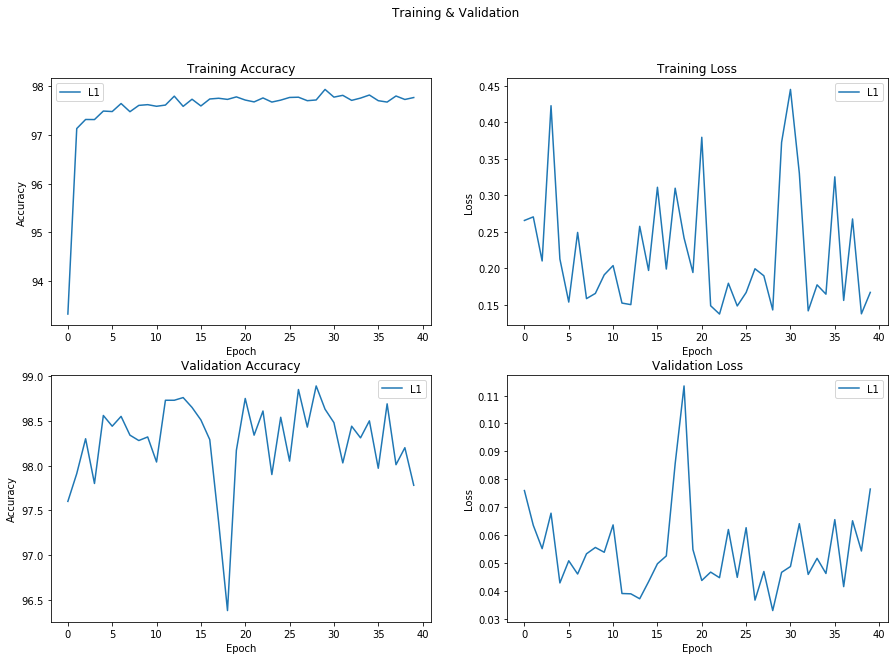

In [17]:
model_l1 = Net().to(device)
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=init_learning_rate, momentum=0.9)
scheduler_l1 = StepLR(optimizer_l1, step_size=1, gamma=gamma)

[(train_acc_l1, train_loss_l1), (val_acc_l1, val_loss_l1)] = train_n_test(model_l1, optimizer_l1, scheduler_l1, device, train_loader, test_loader, EPOCHS, True)

plot_acc_loss({'L1': train_acc_l1}, 
              {'L1': val_acc_l1},
              {'L1': train_loss_l1},
              {'L1': val_loss_l1}
              )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 970    6    2    0    0    0    1    1    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1   14 1013    0    1    0    0    3    0    0]
 [   0    2    4  996    0    2    0    4    2    0]
 [   1    8    0    0  970    0    0    1    0    2]
 [   1    4    0    5    0  873    2    3    1    3]
 [   6   14    1    0    9    1  925    0    2    0]
 [   0   22    7    0    0    0    0  999    0    0]
 [   5   13    8    0    3    2    4    5  934    0]
 [   1   12    1    0   21    0    0    5    5  964]]


              precision    recall  f1-score   support

        zero       0.98      0.99      0.99       980
         one       0.92      1.00      0.96      1135
         two       0.98      0.98      0.98      1032
       three       1.00      0.99      0.99      1010
        four       0.97      0.99      0.98       982
        five       0.99      0.98      0.99       892
         six       0.99      0.97      0.98       958
       seven       0.98      0.97 

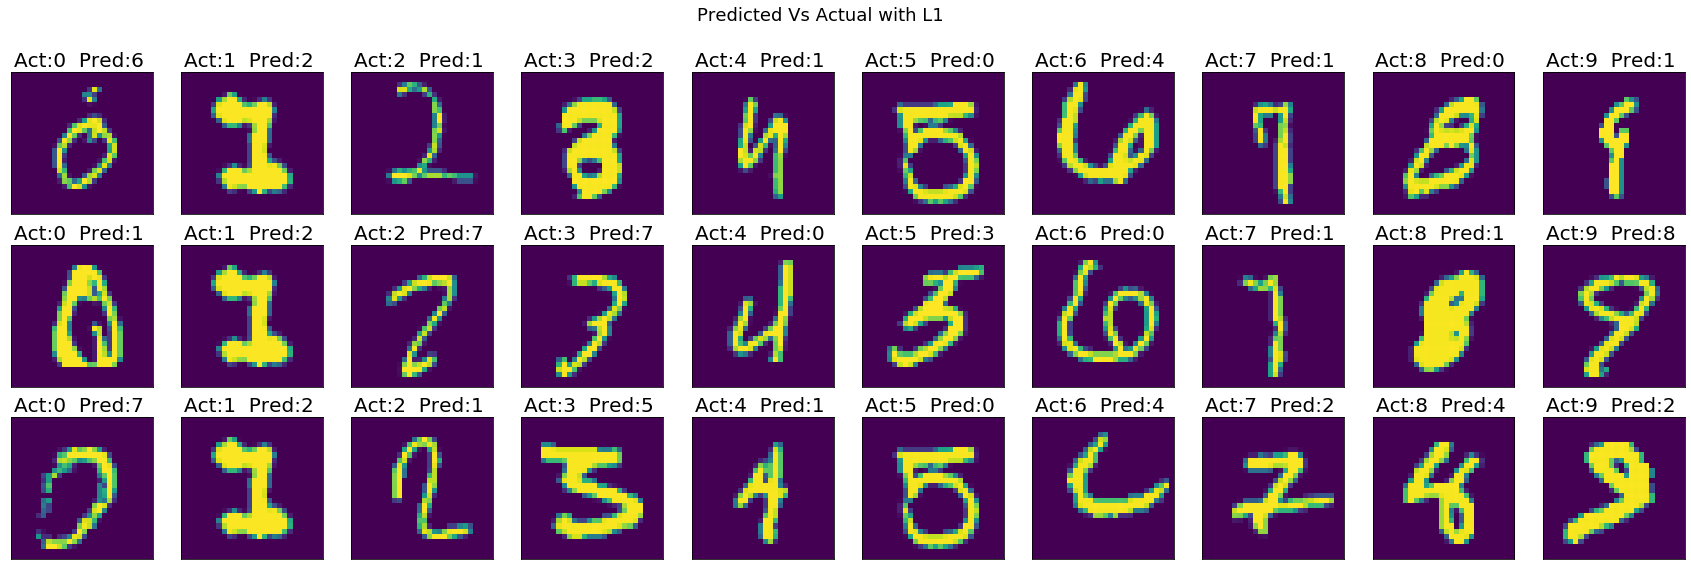

In [18]:
y_pred_l1 = model_pred(model_l1, device, test_dataset)
display_mislabelled(model_l1, device, x_test, y_test.reshape(-1,1), y_pred_l1, 'Predicted Vs Actual with L1')

# Only L2


Epoch: 1, Batch 937,  Training Loss: 0.17237052 Training Accuracy: 92.8517%: 100%|██████████| 938/938 [00:16<00:00, 57.06it/s]


LR: [0.199]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 -- Test Set, Validation Loss: 0.11014320 Validation Accuracy: 96.4700%



Epoch: 2, Batch 937,  Training Loss: 0.08255958 Training Accuracy: 97.0983%: 100%|██████████| 938/938 [00:16<00:00, 56.32it/s]

LR: [0.19899500003140708]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 -- Test Set, Validation Loss: 0.06618014 Validation Accuracy: 97.8100%



Epoch: 3, Batch 937,  Training Loss: 0.04074262 Training Accuracy: 97.5067%: 100%|██████████| 938/938 [00:17<00:00, 54.83it/s]


LR: [0.19899250009422076]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 -- Test Set, Validation Loss: 0.04830798 Validation Accuracy: 98.5700%



Epoch: 4, Batch 937,  Training Loss: 0.03618963 Training Accuracy: 97.6083%: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s]


LR: [0.1989900001884407]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 -- Test Set, Validation Loss: 0.06578446 Validation Accuracy: 97.7800%



Epoch: 5, Batch 937,  Training Loss: 0.11038850 Training Accuracy: 97.6900%: 100%|██████████| 938/938 [00:17<00:00, 54.85it/s]


LR: [0.1989875003140665]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 -- Test Set, Validation Loss: 0.05275307 Validation Accuracy: 98.3200%



Epoch: 6, Batch 937,  Training Loss: 0.10462189 Training Accuracy: 97.6483%: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s]


LR: [0.19898500047109777]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 -- Test Set, Validation Loss: 0.05483479 Validation Accuracy: 98.3700%



Epoch: 7, Batch 937,  Training Loss: 0.04877570 Training Accuracy: 97.6217%: 100%|██████████| 938/938 [00:16<00:00, 55.62it/s]


LR: [0.19898250065953407]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 -- Test Set, Validation Loss: 0.04122924 Validation Accuracy: 98.8400%



Epoch: 8, Batch 937,  Training Loss: 0.02574404 Training Accuracy: 97.8333%: 100%|██████████| 938/938 [00:16<00:00, 56.12it/s]

LR: [0.19898000087937506]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 -- Test Set, Validation Loss: 0.03626826 Validation Accuracy: 98.7400%



Epoch: 9, Batch 937,  Training Loss: 0.04912272 Training Accuracy: 97.8033%: 100%|██████████| 938/938 [00:17<00:00, 54.98it/s]

LR: [0.19897750113062032]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 -- Test Set, Validation Loss: 0.06403343 Validation Accuracy: 97.7800%



Epoch: 10, Batch 937,  Training Loss: 0.15387501 Training Accuracy: 97.8867%: 100%|██████████| 938/938 [00:16<00:00, 58.93it/s]

LR: [0.19897500141326946]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 -- Test Set, Validation Loss: 0.05148953 Validation Accuracy: 98.4600%



Epoch: 11, Batch 937,  Training Loss: 0.05375728 Training Accuracy: 97.8983%: 100%|██████████| 938/938 [00:16<00:00, 55.54it/s]

LR: [0.1989725017273221]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 -- Test Set, Validation Loss: 0.04768388 Validation Accuracy: 98.4500%



Epoch: 12, Batch 937,  Training Loss: 0.02856666 Training Accuracy: 97.9083%: 100%|██████████| 938/938 [00:16<00:00, 55.29it/s]


LR: [0.1989700020727778]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 -- Test Set, Validation Loss: 0.05639803 Validation Accuracy: 98.1600%



Epoch: 13, Batch 937,  Training Loss: 0.03712136 Training Accuracy: 97.9083%: 100%|██████████| 938/938 [00:17<00:00, 55.08it/s]


LR: [0.19896750244963618]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 -- Test Set, Validation Loss: 0.04206928 Validation Accuracy: 98.7000%



Epoch: 14, Batch 937,  Training Loss: 0.01018834 Training Accuracy: 97.9417%: 100%|██████████| 938/938 [00:16<00:00, 57.13it/s]

LR: [0.1989650028578969]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 -- Test Set, Validation Loss: 0.03426254 Validation Accuracy: 98.8800%



Epoch: 15, Batch 937,  Training Loss: 0.01851264 Training Accuracy: 97.9650%: 100%|██████████| 938/938 [00:16<00:00, 56.51it/s]

LR: [0.19896250329755952]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 -- Test Set, Validation Loss: 0.04023825 Validation Accuracy: 98.6800%



Epoch: 16, Batch 937,  Training Loss: 0.04877031 Training Accuracy: 97.9833%: 100%|██████████| 938/938 [00:16<00:00, 56.30it/s]

LR: [0.19896000376862363]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 -- Test Set, Validation Loss: 0.03648514 Validation Accuracy: 98.8400%



Epoch: 17, Batch 937,  Training Loss: 0.01782899 Training Accuracy: 97.9733%: 100%|██████████| 938/938 [00:16<00:00, 55.36it/s]


LR: [0.19895750427108888]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 -- Test Set, Validation Loss: 0.05576882 Validation Accuracy: 98.3100%



Epoch: 18, Batch 937,  Training Loss: 0.02061695 Training Accuracy: 97.8950%: 100%|██████████| 938/938 [00:17<00:00, 52.89it/s]

LR: [0.19895500480495484]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 -- Test Set, Validation Loss: 0.04698004 Validation Accuracy: 98.4400%



Epoch: 19, Batch 937,  Training Loss: 0.00968800 Training Accuracy: 97.9300%: 100%|██████████| 938/938 [00:16<00:00, 55.35it/s]

LR: [0.19895250537022113]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 -- Test Set, Validation Loss: 0.03880979 Validation Accuracy: 98.7300%



Epoch: 20, Batch 937,  Training Loss: 0.05706958 Training Accuracy: 97.9267%: 100%|██████████| 938/938 [00:17<00:00, 56.05it/s]


LR: [0.19895000596688736]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 20 -- Test Set, Validation Loss: 0.05403293 Validation Accuracy: 98.0500%



Epoch: 21, Batch 937,  Training Loss: 0.05241497 Training Accuracy: 97.9400%: 100%|██████████| 938/938 [00:16<00:00, 55.30it/s]

LR: [0.1989475065949531]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 21 -- Test Set, Validation Loss: 0.04352421 Validation Accuracy: 98.6700%



Epoch: 22, Batch 937,  Training Loss: 0.00339085 Training Accuracy: 97.9683%: 100%|██████████| 938/938 [00:16<00:00, 55.47it/s]

LR: [0.19894500725441802]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 22 -- Test Set, Validation Loss: 0.03720494 Validation Accuracy: 98.8100%



Epoch: 23, Batch 937,  Training Loss: 0.00695494 Training Accuracy: 97.9250%: 100%|██████████| 938/938 [00:16<00:00, 57.57it/s]

LR: [0.19894250794528168]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 23 -- Test Set, Validation Loss: 0.03820737 Validation Accuracy: 98.8500%



Epoch: 24, Batch 937,  Training Loss: 0.03832121 Training Accuracy: 97.9400%: 100%|██████████| 938/938 [00:17<00:00, 54.99it/s]

LR: [0.1989400086675437]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 24 -- Test Set, Validation Loss: 0.03491992 Validation Accuracy: 98.8500%



Epoch: 25, Batch 937,  Training Loss: 0.01448825 Training Accuracy: 98.0117%: 100%|██████████| 938/938 [00:17<00:00, 53.75it/s]

LR: [0.19893750942120367]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 25 -- Test Set, Validation Loss: 0.05686122 Validation Accuracy: 98.1900%



Epoch: 26, Batch 937,  Training Loss: 0.17698672 Training Accuracy: 97.9400%: 100%|██████████| 938/938 [00:16<00:00, 58.47it/s]

LR: [0.1989350102062612]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 26 -- Test Set, Validation Loss: 0.04546802 Validation Accuracy: 98.6200%



Epoch: 27, Batch 937,  Training Loss: 0.00785337 Training Accuracy: 98.0150%: 100%|██████████| 938/938 [00:15<00:00, 59.36it/s]

LR: [0.19893251102271592]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 27 -- Test Set, Validation Loss: 0.03678971 Validation Accuracy: 98.8500%



Epoch: 28, Batch 937,  Training Loss: 0.05339985 Training Accuracy: 97.9650%: 100%|██████████| 938/938 [00:16<00:00, 56.55it/s]

LR: [0.1989300118705674]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 28 -- Test Set, Validation Loss: 0.03366029 Validation Accuracy: 98.9100%



Epoch: 29, Batch 937,  Training Loss: 0.01562645 Training Accuracy: 97.9433%: 100%|██████████| 938/938 [00:15<00:00, 58.73it/s]

LR: [0.1989275127498153]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 29 -- Test Set, Validation Loss: 0.03711582 Validation Accuracy: 98.7300%



Epoch: 30, Batch 937,  Training Loss: 0.01487575 Training Accuracy: 97.9617%: 100%|██████████| 938/938 [00:15<00:00, 59.40it/s]

LR: [0.19892501366045917]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 30 -- Test Set, Validation Loss: 0.03652538 Validation Accuracy: 98.8700%



Epoch: 31, Batch 937,  Training Loss: 0.03240195 Training Accuracy: 98.0250%: 100%|██████████| 938/938 [00:16<00:00, 58.59it/s]

LR: [0.19892251460249863]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 31 -- Test Set, Validation Loss: 0.04134303 Validation Accuracy: 98.6300%



Epoch: 32, Batch 937,  Training Loss: 0.08820465 Training Accuracy: 97.9383%: 100%|██████████| 938/938 [00:15<00:00, 58.75it/s]

LR: [0.19892001557593328]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 32 -- Test Set, Validation Loss: 0.03853470 Validation Accuracy: 98.8400%



Epoch: 33, Batch 937,  Training Loss: 0.24745698 Training Accuracy: 98.0117%: 100%|██████████| 938/938 [00:15<00:00, 58.68it/s]


LR: [0.19891751658076276]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 33 -- Test Set, Validation Loss: 0.05036639 Validation Accuracy: 98.4500%



Epoch: 34, Batch 937,  Training Loss: 0.04459165 Training Accuracy: 97.8983%: 100%|██████████| 938/938 [00:15<00:00, 59.95it/s]


LR: [0.19891501761698663]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 34 -- Test Set, Validation Loss: 0.04035290 Validation Accuracy: 98.7600%



Epoch: 35, Batch 937,  Training Loss: 0.08327827 Training Accuracy: 98.0317%: 100%|██████████| 938/938 [00:16<00:00, 58.10it/s]

LR: [0.19891251868460452]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 35 -- Test Set, Validation Loss: 0.04144382 Validation Accuracy: 98.7800%



Epoch: 36, Batch 937,  Training Loss: 0.01152749 Training Accuracy: 97.9800%: 100%|██████████| 938/938 [00:15<00:00, 60.83it/s]

LR: [0.19891001978361605]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 36 -- Test Set, Validation Loss: 0.04896532 Validation Accuracy: 98.5000%



Epoch: 37, Batch 937,  Training Loss: 0.00982684 Training Accuracy: 98.0333%: 100%|██████████| 938/938 [00:16<00:00, 57.04it/s]

LR: [0.1989075209140208]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 37 -- Test Set, Validation Loss: 0.03783322 Validation Accuracy: 98.8200%



Epoch: 38, Batch 937,  Training Loss: 0.02631299 Training Accuracy: 97.9383%: 100%|██████████| 938/938 [00:16<00:00, 58.18it/s]

LR: [0.1989050220758184]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 38 -- Test Set, Validation Loss: 0.03861915 Validation Accuracy: 98.7700%



Epoch: 39, Batch 937,  Training Loss: 0.16096300 Training Accuracy: 97.9933%: 100%|██████████| 938/938 [00:16<00:00, 58.51it/s]

LR: [0.19890252326900842]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 39 -- Test Set, Validation Loss: 0.03362309 Validation Accuracy: 98.9800%



Epoch: 40, Batch 937,  Training Loss: 0.01037636 Training Accuracy: 97.9650%: 100%|██████████| 938/938 [00:15<00:00, 62.71it/s]

LR: [0.19890002449359048]



Epoch: 40 -- Test Set, Validation Loss: 0.03406551 Validation Accuracy: 99.0000%



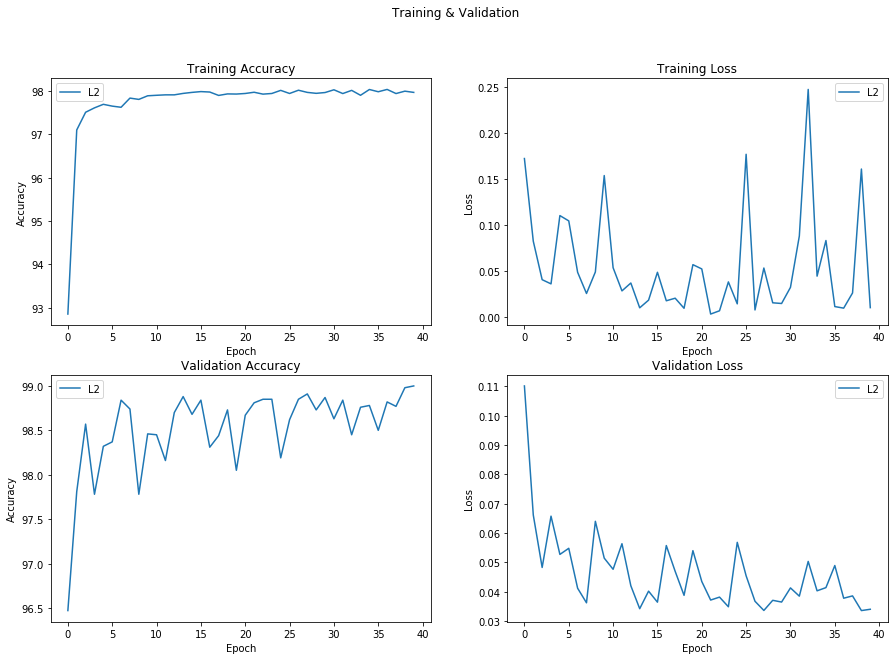

In [19]:
l2_weight_decay = 0.0002125

model_l2 = Net().to(device)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=init_learning_rate, momentum=0.9, weight_decay=l2_weight_decay)
scheduler_l2 = StepLR(optimizer_l2, step_size=1, gamma=gamma)

[(train_acc_l2, train_loss_l2), (val_acc_l2, val_loss_l2)] = train_n_test(model_l2, optimizer_l2, scheduler_l2, device, train_loader, test_loader, EPOCHS)

plot_acc_loss({'L2': train_acc_l2}, 
              {'L2': val_acc_l2},
              {'L2': train_loss_l2},
              {'L2': val_loss_l2}
              )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 972    0    1    0    0    1    5    1    0    0]
 [   0 1131    0    2    0    0    2    0    0    0]
 [   0    3 1016    2    0    0    3    7    1    0]
 [   0    0    0 1004    0    4    0    1    0    1]
 [   0    2    0    0  975    0    1    0    0    4]
 [   0    0    0    3    0  887    2    0    0    0]
 [   0    1    0    0    2    1  954    0    0    0]
 [   0   10    4    1    1    1    0 1010    0    1]
 [   0    1    1    3    0    1    0    0  967    1]
 [   0    2    0    0    7    7    0    5    4  984]]


              precision    recall  f1-score   support

        zero       1.00      0.99      1.00       980
         one       0.98      1.00      0.99      1135
         two       0.99      0.98      0.99      1032
       three       0.99      0.99      0.99      1010
        four       0.99      0.99      0.99       982
        five       0.98      0.99      0.99       892
         six       0.99      1.00      0.99       958
       seven       0.99      0.98 

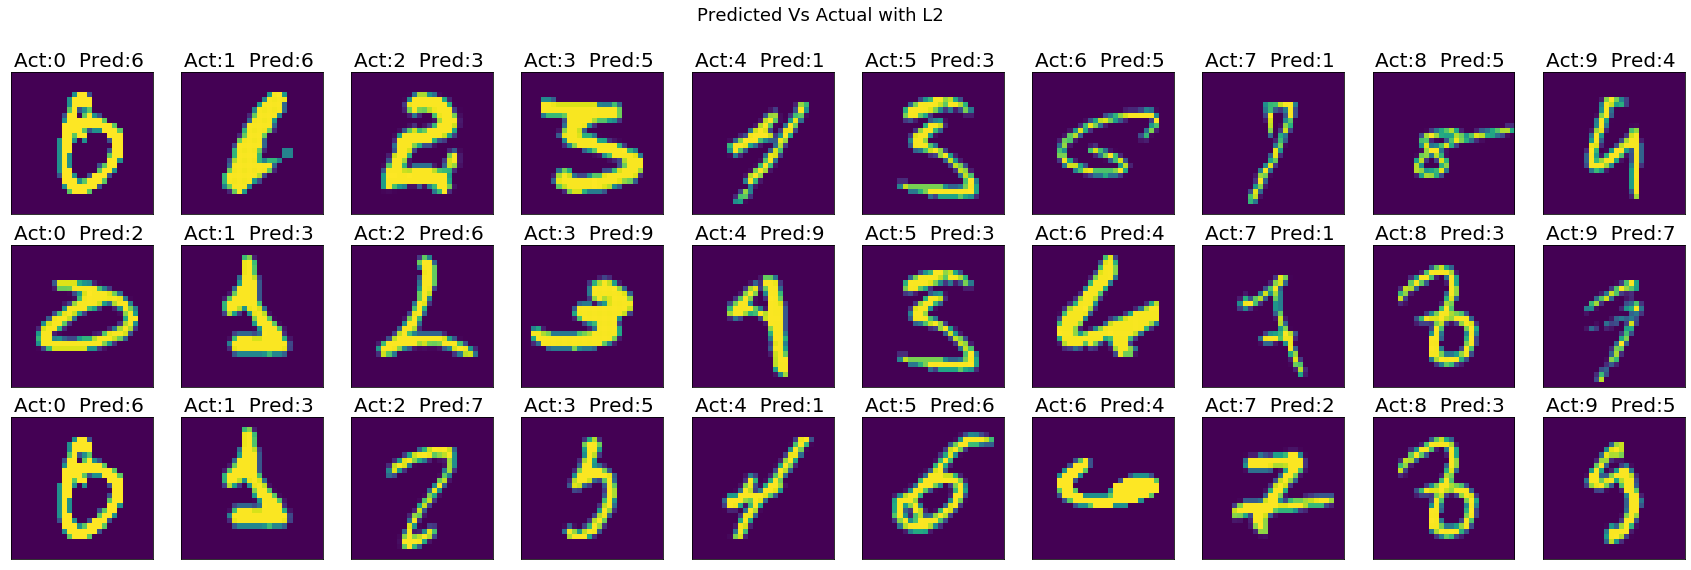

In [20]:
y_pred_l2 = model_pred(model_l2, device, test_dataset)
display_mislabelled(model_l2, device, x_test, y_test.reshape(-1,1), y_pred_l2, 'Predicted Vs Actual with L2')

# L1 and L2


Epoch: 1, Batch 937,  Training Loss: 0.38174593 Training Accuracy: 92.4350%: 100%|██████████| 938/938 [00:16<00:00, 54.60it/s]

LR: [0.199]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 -- Test Set, Validation Loss: 0.08195946 Validation Accuracy: 97.3600%



Epoch: 2, Batch 937,  Training Loss: 0.18712592 Training Accuracy: 96.4233%: 100%|██████████| 938/938 [00:16<00:00, 55.21it/s]


LR: [0.19899500003140708]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 -- Test Set, Validation Loss: 0.09193989 Validation Accuracy: 97.2400%



Epoch: 3, Batch 937,  Training Loss: 0.18063895 Training Accuracy: 96.7083%: 100%|██████████| 938/938 [00:16<00:00, 55.83it/s]

LR: [0.19899250009422076]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 -- Test Set, Validation Loss: 0.05960853 Validation Accuracy: 98.1300%



Epoch: 4, Batch 937,  Training Loss: 0.22686493 Training Accuracy: 96.7767%: 100%|██████████| 938/938 [00:16<00:00, 55.74it/s]

LR: [0.1989900001884407]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 -- Test Set, Validation Loss: 0.07517438 Validation Accuracy: 97.6700%



Epoch: 5, Batch 937,  Training Loss: 0.16050458 Training Accuracy: 96.9767%: 100%|██████████| 938/938 [00:17<00:00, 53.24it/s]

LR: [0.1989875003140665]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 -- Test Set, Validation Loss: 0.08017420 Validation Accuracy: 97.2600%



Epoch: 6, Batch 937,  Training Loss: 0.19824538 Training Accuracy: 96.9283%: 100%|██████████| 938/938 [00:16<00:00, 55.91it/s]

LR: [0.19898500047109777]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 -- Test Set, Validation Loss: 0.08592003 Validation Accuracy: 97.0500%



Epoch: 7, Batch 937,  Training Loss: 0.19103742 Training Accuracy: 96.9217%: 100%|██████████| 938/938 [00:16<00:00, 55.83it/s]

LR: [0.19898250065953407]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 -- Test Set, Validation Loss: 0.06609905 Validation Accuracy: 97.9600%



Epoch: 8, Batch 937,  Training Loss: 0.15589651 Training Accuracy: 97.0717%: 100%|██████████| 938/938 [00:17<00:00, 55.00it/s]

LR: [0.19898000087937506]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 -- Test Set, Validation Loss: 0.08225710 Validation Accuracy: 97.3400%



Epoch: 9, Batch 937,  Training Loss: 0.14471529 Training Accuracy: 96.9833%: 100%|██████████| 938/938 [00:16<00:00, 55.40it/s]

LR: [0.19897750113062032]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 -- Test Set, Validation Loss: 0.06004063 Validation Accuracy: 98.1100%



Epoch: 10, Batch 937,  Training Loss: 0.17596325 Training Accuracy: 97.0350%: 100%|██████████| 938/938 [00:17<00:00, 63.08it/s]

LR: [0.19897500141326946]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 -- Test Set, Validation Loss: 0.06767323 Validation Accuracy: 97.8600%



Epoch: 11, Batch 937,  Training Loss: 0.13655132 Training Accuracy: 96.9650%: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s]

LR: [0.1989725017273221]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 -- Test Set, Validation Loss: 0.04898138 Validation Accuracy: 98.4000%



Epoch: 12, Batch 937,  Training Loss: 0.20527223 Training Accuracy: 97.0267%: 100%|██████████| 938/938 [00:16<00:00, 57.20it/s]


LR: [0.1989700020727778]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 -- Test Set, Validation Loss: 0.07566264 Validation Accuracy: 97.7400%



Epoch: 13, Batch 937,  Training Loss: 0.16487563 Training Accuracy: 97.0050%: 100%|██████████| 938/938 [00:17<00:00, 53.94it/s]

LR: [0.19896750244963618]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 -- Test Set, Validation Loss: 0.05658981 Validation Accuracy: 98.2000%



Epoch: 14, Batch 937,  Training Loss: 0.15290830 Training Accuracy: 97.0083%: 100%|██████████| 938/938 [00:17<00:00, 53.72it/s]

LR: [0.1989650028578969]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 -- Test Set, Validation Loss: 0.09473432 Validation Accuracy: 97.0500%



Epoch: 15, Batch 937,  Training Loss: 0.30037028 Training Accuracy: 97.0933%: 100%|██████████| 938/938 [00:17<00:00, 54.16it/s]

LR: [0.19896250329755952]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 -- Test Set, Validation Loss: 0.04844420 Validation Accuracy: 98.3800%



Epoch: 16, Batch 937,  Training Loss: 0.24063842 Training Accuracy: 97.0800%: 100%|██████████| 938/938 [00:16<00:00, 57.07it/s]

LR: [0.19896000376862363]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 -- Test Set, Validation Loss: 0.08964594 Validation Accuracy: 97.1000%



Epoch: 17, Batch 937,  Training Loss: 0.12949394 Training Accuracy: 97.0200%: 100%|██████████| 938/938 [00:17<00:00, 54.56it/s]

LR: [0.19895750427108888]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 -- Test Set, Validation Loss: 0.11985280 Validation Accuracy: 96.1100%



Epoch: 18, Batch 937,  Training Loss: 0.13232067 Training Accuracy: 97.0333%: 100%|██████████| 938/938 [00:17<00:00, 62.85it/s]

LR: [0.19895500480495484]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 -- Test Set, Validation Loss: 0.04436959 Validation Accuracy: 98.5700%



Epoch: 19, Batch 937,  Training Loss: 0.20662794 Training Accuracy: 97.1000%: 100%|██████████| 938/938 [00:16<00:00, 55.81it/s]

LR: [0.19895250537022113]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 -- Test Set, Validation Loss: 0.11333207 Validation Accuracy: 96.3400%



Epoch: 20, Batch 937,  Training Loss: 0.21045196 Training Accuracy: 97.1350%: 100%|██████████| 938/938 [00:16<00:00, 55.21it/s]

LR: [0.19895000596688736]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 20 -- Test Set, Validation Loss: 0.07482111 Validation Accuracy: 97.7000%



Epoch: 21, Batch 937,  Training Loss: 0.14248215 Training Accuracy: 97.1417%: 100%|██████████| 938/938 [00:16<00:00, 55.92it/s]

LR: [0.1989475065949531]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 21 -- Test Set, Validation Loss: 0.08093161 Validation Accuracy: 97.4900%



Epoch: 22, Batch 937,  Training Loss: 0.16650155 Training Accuracy: 97.1217%: 100%|██████████| 938/938 [00:16<00:00, 56.57it/s]

LR: [0.19894500725441802]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 22 -- Test Set, Validation Loss: 0.08955393 Validation Accuracy: 97.2200%



Epoch: 23, Batch 937,  Training Loss: 0.13018999 Training Accuracy: 97.1383%: 100%|██████████| 938/938 [00:17<00:00, 58.20it/s]

LR: [0.19894250794528168]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 23 -- Test Set, Validation Loss: 0.06386187 Validation Accuracy: 98.0700%



Epoch: 24, Batch 937,  Training Loss: 0.28642949 Training Accuracy: 97.0750%: 100%|██████████| 938/938 [00:17<00:00, 54.98it/s]

LR: [0.1989400086675437]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 24 -- Test Set, Validation Loss: 0.12033127 Validation Accuracy: 96.1100%



Epoch: 25, Batch 937,  Training Loss: 0.19577140 Training Accuracy: 97.0833%: 100%|██████████| 938/938 [00:16<00:00, 56.37it/s]

LR: [0.19893750942120367]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 25 -- Test Set, Validation Loss: 0.08633509 Validation Accuracy: 97.0100%



Epoch: 26, Batch 937,  Training Loss: 0.24458835 Training Accuracy: 97.0983%: 100%|██████████| 938/938 [00:16<00:00, 55.60it/s]


LR: [0.1989350102062612]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 26 -- Test Set, Validation Loss: 0.09393531 Validation Accuracy: 96.8000%



Epoch: 27, Batch 937,  Training Loss: 0.20860828 Training Accuracy: 97.1083%: 100%|██████████| 938/938 [00:17<00:00, 54.46it/s]

LR: [0.19893251102271592]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 27 -- Test Set, Validation Loss: 0.06795763 Validation Accuracy: 98.1000%



Epoch: 28, Batch 937,  Training Loss: 0.15928711 Training Accuracy: 97.0883%: 100%|██████████| 938/938 [00:17<00:00, 54.56it/s]

LR: [0.1989300118705674]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 28 -- Test Set, Validation Loss: 0.05495996 Validation Accuracy: 98.3300%



Epoch: 29, Batch 937,  Training Loss: 0.13030897 Training Accuracy: 97.1433%: 100%|██████████| 938/938 [00:17<00:00, 54.62it/s]

LR: [0.1989275127498153]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 29 -- Test Set, Validation Loss: 0.05594068 Validation Accuracy: 98.2600%



Epoch: 30, Batch 937,  Training Loss: 0.13478191 Training Accuracy: 97.0750%: 100%|██████████| 938/938 [00:17<00:00, 54.83it/s]

LR: [0.19892501366045917]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 30 -- Test Set, Validation Loss: 0.18327780 Validation Accuracy: 93.9700%



Epoch: 31, Batch 937,  Training Loss: 0.14131892 Training Accuracy: 97.1467%: 100%|██████████| 938/938 [00:17<00:00, 54.75it/s]


LR: [0.19892251460249863]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 31 -- Test Set, Validation Loss: 0.07978161 Validation Accuracy: 97.4700%



Epoch: 32, Batch 937,  Training Loss: 0.33952951 Training Accuracy: 96.9867%: 100%|██████████| 938/938 [00:17<00:00, 54.05it/s]


LR: [0.19892001557593328]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 32 -- Test Set, Validation Loss: 0.07087757 Validation Accuracy: 97.8700%



Epoch: 33, Batch 937,  Training Loss: 0.16253561 Training Accuracy: 97.1567%: 100%|██████████| 938/938 [00:17<00:00, 53.72it/s]

LR: [0.19891751658076276]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 33 -- Test Set, Validation Loss: 0.06206734 Validation Accuracy: 98.1100%



Epoch: 34, Batch 937,  Training Loss: 0.29177448 Training Accuracy: 97.1583%: 100%|██████████| 938/938 [00:17<00:00, 62.50it/s]

LR: [0.19891501761698663]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 34 -- Test Set, Validation Loss: 0.06469709 Validation Accuracy: 97.9400%



Epoch: 35, Batch 937,  Training Loss: 0.14754860 Training Accuracy: 96.9600%: 100%|██████████| 938/938 [00:17<00:00, 54.69it/s]

LR: [0.19891251868460452]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 35 -- Test Set, Validation Loss: 0.07000783 Validation Accuracy: 97.7800%



Epoch: 36, Batch 937,  Training Loss: 0.42161140 Training Accuracy: 97.1217%: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]

LR: [0.19891001978361605]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 36 -- Test Set, Validation Loss: 0.09138105 Validation Accuracy: 97.0100%



Epoch: 37, Batch 937,  Training Loss: 0.25459328 Training Accuracy: 97.1467%: 100%|██████████| 938/938 [00:16<00:00, 55.85it/s]

LR: [0.1989075209140208]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 37 -- Test Set, Validation Loss: 0.12302557 Validation Accuracy: 96.1600%



Epoch: 38, Batch 937,  Training Loss: 0.17773426 Training Accuracy: 96.9650%: 100%|██████████| 938/938 [00:16<00:00, 56.00it/s]

LR: [0.1989050220758184]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 38 -- Test Set, Validation Loss: 0.05504848 Validation Accuracy: 98.3900%



Epoch: 39, Batch 937,  Training Loss: 0.39900380 Training Accuracy: 97.2667%: 100%|██████████| 938/938 [00:17<00:00, 53.73it/s]

LR: [0.19890252326900842]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 39 -- Test Set, Validation Loss: 0.05881303 Validation Accuracy: 97.9100%



Epoch: 40, Batch 937,  Training Loss: 0.35276812 Training Accuracy: 97.1383%: 100%|██████████| 938/938 [00:17<00:00, 54.93it/s]

LR: [0.19890002449359048]



Epoch: 40 -- Test Set, Validation Loss: 0.05105961 Validation Accuracy: 98.5400%



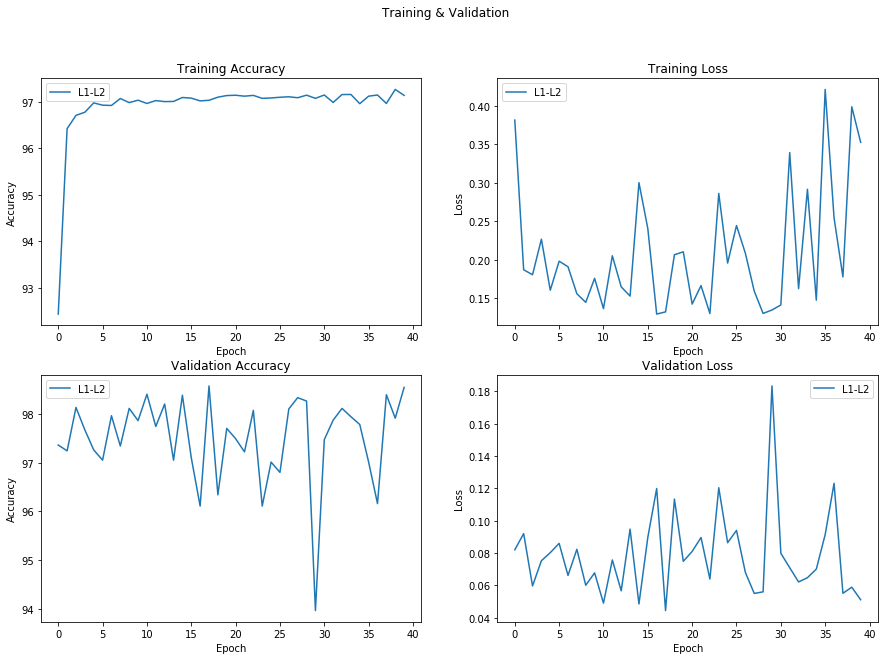

In [21]:
model_l1_l2 = Net().to(device)
optimizer_l1_l2 = optim.SGD(model_l1_l2.parameters(), lr=init_learning_rate, momentum=0.9, weight_decay=l2_weight_decay)
scheduler_l1_l2 = StepLR(optimizer_l1_l2, step_size=1, gamma=gamma)

[(train_acc_l1_l2, train_loss_l1_l2), (val_acc_l1_l2, val_loss_l1_l2)] = train_n_test(model_l1_l2, optimizer_l1_l2, scheduler_l1_l2, device, train_loader, test_loader, EPOCHS, True)

plot_acc_loss({'L1-L2': train_acc_l1_l2}, 
              {'L1-L2': val_acc_l1_l2},
              {'L1-L2': train_loss_l1_l2},
              {'L1-L2': val_loss_l1_l2}
              )




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 974    0    1    0    0    0    4    1    0    0]
 [   4 1121    4    3    0    0    1    1    1    0]
 [   5    0 1023    1    0    0    0    0    3    0]
 [   0    0    0 1007    0    1    0    0    1    1]
 [   1    0    0    0  963    0    0    0    3   15]
 [   2    1    0   15    1  852    8    1    5    7]
 [   4    5    1    0    3    0  945    0    0    0]
 [   1    4    9    3    0    1    0 1008    0    2]
 [   1    0    0    4    0    0    1    1  966    1]
 [   2    0    0    0    5    1    0    3    3  995]]


              precision    recall  f1-score   support

        zero       0.98      0.99      0.99       980
         one       0.99      0.99      0.99      1135
         two       0.99      0.99      0.99      1032
       three       0.97      1.00      0.99      1010
        four       0.99      0.98      0.99       982
        five       1.00      0.96      0.98       892
         six       0.99      0.99      0.99       958
       seven       0.99      0.98 

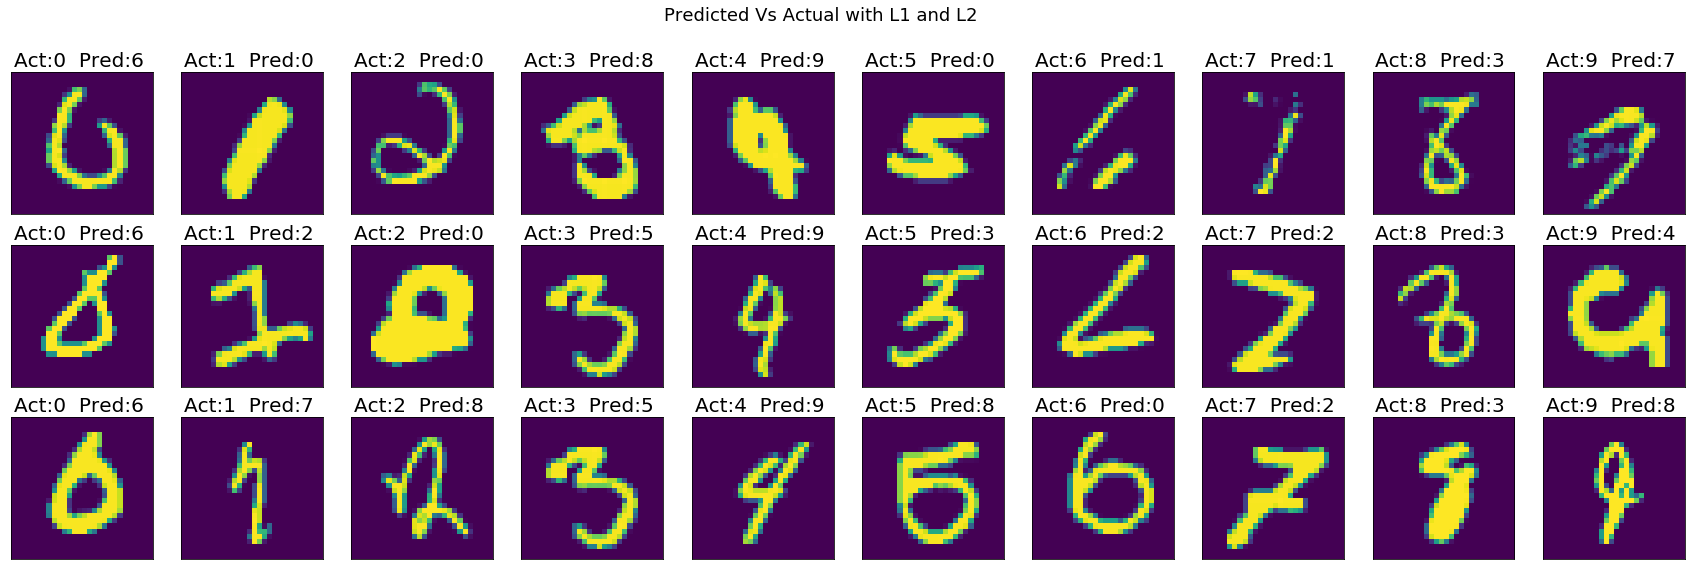

In [22]:
y_pred_l1_l2 = model_pred(model_l1_l2, device, test_dataset)
display_mislabelled(model_l1_l2, device, x_test, y_test.reshape(-1,1), y_pred_l1_l2, 'Predicted Vs Actual with L1 and L2')

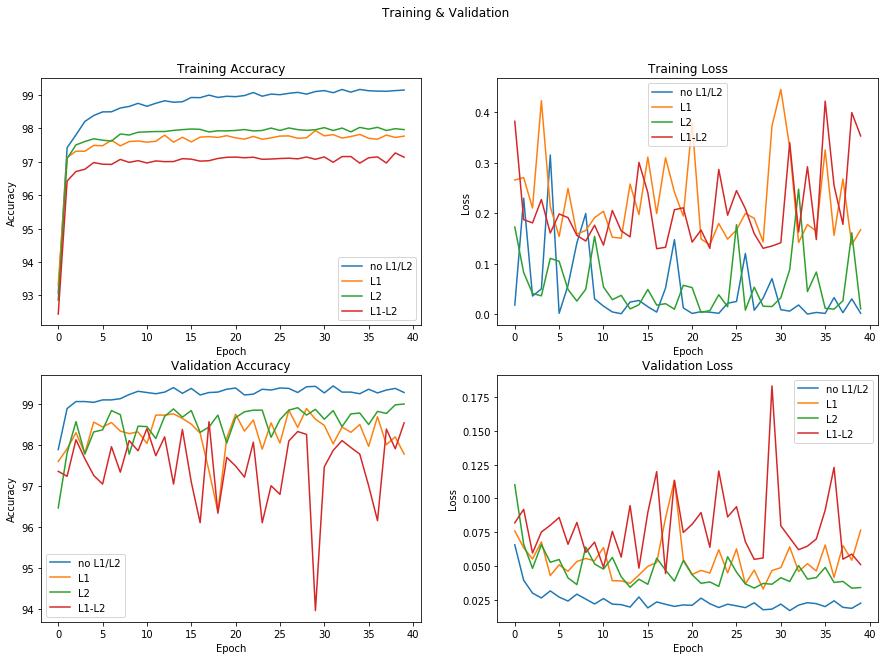

In [23]:
plot_acc_loss(
    {'no L1/L2': train_acc_1, 'L1': train_acc_l1, 'L2': train_acc_l2, 'L1-L2': train_acc_l1_l2}, 
    {'no L1/L2': val_acc_1, 'L1': val_acc_l1, 'L2': val_acc_l2, 'L1-L2': val_acc_l1_l2},
    {'no L1/L2': train_loss_1, 'L1': train_loss_l1, 'L2': train_loss_l2, 'L1-L2': train_loss_l1_l2},
    {'no L1/L2': val_loss_1, 'L1': val_loss_l1, 'L2': val_loss_l2, 'L1-L2': val_loss_l1_l2}
)